# 2024 Harris vs. Trump Election Prediction
The practice followed [ritvikmath](https://www.youtube.com/watch?v=O5-A2ensKb0) guidance on utilizing Bayesian methodology, using 2020 election data (`prior`), with current polling data of 7 swing states (`likelihood`) to get 2024 election prediction (`posterior`). A baseline level of uncertainty is allowed for the prediction, which usually becomes lower as we get clower to the date of election.

In [ ]:
!pip install numpy pandas matplotlib seaborn requests bs4 geopandas descartes wget scipy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import urllib3 # to bypass SSL verification and suppress warnings (not recommended for production level)
import os 
import scipy.stats as stats
import geopandas as gpd
import wget
# print(os.getcwd()) #print the current working directory

In [2]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None) #None as no column limit for display

Get the voting states and respective electoral votes:

In [2]:
cwd = os.getcwd()
relative_path = "votingState.txt"
file_path = os.path.join(cwd, relative_path)

In [3]:
with open(file_path, 'r') as file:
    text = file.read()
    print(text[:100])


Alabama - 9 votes

Kentucky - 8 votes

North Dakota - 3 votes

Alaska - 3 votes

Louisiana - 8 votes


In [4]:
# Regex pattern to find state name
pattern = r"^[A-Za-z\s]+(?=\s*-\s*\d+\s*votes\n)"
voting_states = re.findall(pattern, text, flags=re.M)
voting_states = [match.strip() for match in voting_states]
print(voting_states)

['Alabama', 'Kentucky', 'North Dakota', 'Alaska', 'Louisiana', 'Ohio', 'Arizona', 'Maine', 'Oklahoma', 'Arkansas', 'Maryland', 'Oregon', 'California', 'Massachusetts', 'Pennsylvania', 'Colorado', 'Michigan', 'Rhode Island', 'Connecticut', 'Minnesota', 'South Carolina', 'Delaware', 'Mississippi', 'South Dakota', 'District of Columbia', 'Missouri', 'Tennessee', 'Florida', 'Montana', 'Texas', 'Georgia', 'Nebraska', 'Utah', 'Hawaii', 'Nevada', 'Vermont', 'Idaho', 'New Hampshire', 'Virginia', 'Illinois', 'New Jersey', 'Washington', 'Indiana', 'New Mexico', 'West Virginia', 'Iowa', 'New York', 'Wisconsin', 'Kansas', 'North Carolina']


* `^` anchor the start of each line
* `re.M` allows `^` to work on each line independently
* `str.strip()` to remove any leading or trailing whitespace
* `\s` match any whitespace character


## 1. Read 2020 Election Data

In [6]:
cwd = os.getcwd()
relative_path = "2020_election_results.txt"
file_path = os.path.join(cwd, relative_path)

In [ ]:
# read 2020 election result text file and extract 
try:
    with open(file_path, 'r') as file:
        text = file.read()
    print(text[:200]) # display the first 200 characters to confirm success
except FileNotFoundError:
    print(f"File not found at {file_path}")
except UnicodeDecodeError:
    print(f"Encoding issue while reading the file. Try another eoncding.")


STATE RESULTS
President: Alabama
9 Electoral Votes
Trump
PROJECTED WINNER
+ FOLLOW
Candidate	%		Votes
Trump
62.0%	
1,441,170
Biden
36.6%	
849,624
Est. 99% In
Updated 10:17 p.m. ET, Mar. 6
Full Details


[`regex`](https://www.w3schools.com/python/python_regex.asp) to extract expression pattern, and comfile the matches into dataframe:

In [8]:
pattern = (
    # Lines begin with 'President', followed by the state name into 'state' column
    r"President:\s*(?P<state>[A-Za-z\s]+)\n"
    r"(?P<electoral_votes>\d+)\s*Electoral Votes\n"
    r"(?P<winner>Trump|Biden)\nPROJECTED WINNER\n\+ FOLLOW\n"
    # votes-name
    r"Candidate\t%\t\tVotes\n(?P<candidate1>Trump|Biden)\n(?:\d+\.\d+%)?\s*\n?(?P<votes1>[\d,]+)\n(?P<candidate2>Trump|Biden)\n(?:\d+.\d+%)?s*\n?(?P<votes2>[\d,]+)"
)

In [9]:
# Compile the regrex pattern
regex = re.compile(pattern)

# Find all matches in the text and return a list of tuples
# matches = regex.findall(text)
matches = regex.finditer(text)

In [ ]:
# matches

[('Alabama', '9', 'Trump', 'Trump', '1,441,170', 'Biden', '36'), ('Alaska', '3', 'Trump', 'Trump', '189,951', 'Biden', '42'), ('Arizona\nParty change\nBATTLEGROUND', '11', 'Biden', 'Biden', '1,672,143', 'Trump', '49'), ('Arkansas', '6', 'Trump', 'Trump', '760,647', 'Biden', '34'), ('California', '55', 'Biden', 'Biden', '11,110,250', 'Trump', '34'), ('Colorado\nBATTLEGROUND', '9', 'Biden', 'Biden', '1,804,352', 'Trump', '41'), ('Connecticut', '7', 'Biden', 'Biden', '1,080,831', 'Trump', '39'), ('Delaware', '3', 'Biden', 'Biden', '296,268', 'Trump', '39'), ('District Of Columbia', '3', 'Biden', 'Biden', '317,323', 'Trump', '5'), ('Florida\nBATTLEGROUND', '29', 'Trump', 'Trump', '5,668,731', 'Biden', '47'), ('Georgia\nParty change\nBATTLEGROUND', '16', 'Biden', 'Biden', '2,473,633', 'Trump', '49'), ('Hawaii', '4', 'Biden', 'Biden', '366,130', 'Trump', '34'), ('Idaho', '4', 'Trump', 'Trump', '554,119', 'Biden', '33'), ('Illinois', '20', 'Biden', 'Biden', '3,471,915', 'Trump', '40'), ('Indi

* `matches` is a list of tuples
    * if using `re.findall()`, can only access with index such as `match[0]`. 
    * Or use `re.finditer()` to return match objects (so that you could use `.group()` later

In [10]:
# Process the matches
results = []
for match in matches:
    candidate1 = match.group('candidate1')
    votes1 = int(match.group('votes1').replace(',',''))
    candidate2 = match.group('candidate2')
    votes2 = int(match.group('votes2').replace(',',''))  

    # Assign votes to candidates
    if candidate1 == 'Trump':
        trump_votes, biden_votes = votes1, votes2
    else:
        trump_votes, biden_votes = votes2, votes1
    
    # Append the results
    results.append({
        "State": match.group('state'), #instead of match[0] (to prevent indexing error)
        # winner takes all
        "Electoral Votes": int(match.group('electoral_votes')),
        "Winner": match.group('winner'),
        "Trump Votes": trump_votes,
        "Biden Votes": biden_votes
    })

voting_df = pd.DataFrame(results)


In [11]:
voting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   State            49 non-null     object
 1   Electoral Votes  49 non-null     int64 
 2   Winner           49 non-null     object
 3   Trump Votes      49 non-null     int64 
 4   Biden Votes      49 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.0+ KB


In [12]:
# Winner takes all
voting_df['Trump Electoral Votes'] = voting_df.apply(lambda row: row['Electoral Votes'] if row.Winner == 'Trump' else 0, 1) 
voting_df['Biden Electoral Votes'] = voting_df.apply(lambda row: row['Electoral Votes'] if row.Winner == 'Biden' else 0, 1)

In [13]:
voting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   State                  49 non-null     object
 1   Electoral Votes        49 non-null     int64 
 2   Winner                 49 non-null     object
 3   Trump Votes            49 non-null     int64 
 4   Biden Votes            49 non-null     int64 
 5   Trump Electoral Votes  49 non-null     int64 
 6   Biden Electoral Votes  49 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 2.8+ KB


In [14]:
voting_df.head()

,State,Electoral Votes,Winner,Trump Votes,Biden Votes,Trump Electoral Votes,Biden Electoral Votes
0,Alabama,9,Trump,1441170,36,9,0
1,Alaska,3,Trump,189951,42,3,0
2,Arizona\nParty change\nBATTLEGROUND,11,Biden,49,1672143,0,11
3,Arkansas,6,Trump,760647,34,6,0
4,California,55,Biden,34,11110250,0,55


From above we see that State column requires cleansing: 
-> split on newline character(`\n`) and takes only the first index

In [15]:
voting_df.State = voting_df.State.apply(lambda x: x.split('\n')[0]) 

Check if there's missing data: 
* `set()` are optimized for operations like `difference` or `intersection`, faster than comparing 2 lists directly, and it automatically removes duplicates

In [16]:
present_states = set(voting_df.State)
missing_states = set(voting_states) - present_states
print(missing_states)

{'Nebraska', 'Maine', 'District of Columbia'}


In [25]:
voting_df.State.unique

<bound method Series.unique of 0                  Alabama
1                   Alaska
2                  Arizona
3                 Arkansas
4               California
5                 Colorado
6              Connecticut
7                 Delaware
8     District Of Columbia
9                  Florida
10                 Georgia
11                  Hawaii
12                   Idaho
13                Illinois
14                 Indiana
15                    Iowa
16                  Kansas
17                Kentucky
18               Louisiana
19                Maryland
20           Massachusetts
21                Michigan
22               Minnesota
23             Mississippi
24                Missouri
25                 Montana
26                  Nevada
27           New Hampshire
28              New Jersey
29              New Mexico
30                New York
31          North Carolina
32            North Dakota
33                    Ohio
34                Oklahoma
35                  Oreg

We have `District Of Columbia`, but indeed missing the other two.

`voting_df['State']` is a pandas Series, so we use `isin()`

In [14]:
na_df = voting_df[voting_df['State'].isin(missing_states)] 
print(na_df)

Empty DataFrame
Columns: [State, Electoral Votes, Winner, Trump Votes, Biden Votes, Trump Electoral Votes, Biden Electoral Votes]
Index: []


In [15]:
dc_rows = voting_df[voting_df['State'] == 'District Of Columbia']
print("Rows with District of Columbia:")
print(dc_rows)


Rows with District of Columbia:
                  State  Electoral Votes Winner  Trump Votes  Biden Votes  \
8  District Of Columbia                3  Biden            5       317323   

   Trump Electoral Votes  Biden Electoral Votes  
8                      0                      3  


Confirmed that it's font size issue.

In [17]:
# Add missing data
missing_df = pd.DataFrame(
    columns=voting_df.columns,
    data=[['Maine', 4, 'Biden', 360737, 435072, 1, 3], ['Nebraska', 5, 'Trump', 556846, 374583, 4, 1]]
)

voting_df = pd.concat([voting_df, missing_df])

voting_df = voting_df.sort_values('State').reset_index(drop=True)

In [28]:
voting_df.head()

,State,Electoral Votes,Winner,Trump Votes,Biden Votes,Trump Electoral Votes,Biden Electoral Votes
0,Alabama,9,Trump,1441170,36,9,0
1,Alaska,3,Trump,189951,42,3,0
2,Arizona,11,Biden,49,1672143,0,11
3,Arkansas,6,Trump,760647,34,6,0
4,California,55,Biden,34,11110250,0,55


## Scrape latest state-level polling data

Source: [538 Polls data](https://projects.fivethirtyeight.com/polls/president-general)

In [18]:
# Suppress warnings if SSL verification is disabled
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Core Scraper
* If data is misssing, fill with nataional data.
* Extract poll data from the correct table rows (`<tr>`)
* Handle structure variation (eg. missing poll results, different candidate names)
* Store daata in a structured dictionary for a easy conversion to dataframe
---
* `fina_all()` returns multiple elements, but as we need only one, could use `find()` instead to search for a single element.
* `str.contains()` to return matches like "Biden", "Harris".
* Since the percentage is inside a `<div>`, we need to access the `<div>` first.
* Ensure we always use "Harris" as it could be `array(['Kennedy', 'Harris', 'Biden'], dtype=object)`

Found Trump's polling result as this for those having "More" toggle:
```
<tr class="expandable-row">
...
   </div>
   <div class="value hide-mobile expandable">
    <div class="heat-map" style="background-color:#dc543f;color:#ffffff;">
     59%
    </div>
    <span class="choiceName">
     Trump
    </span>
   </div>
   <div class="value hide-mobile expandable">
```

In [19]:
# Fallback: national polling url
NATIONAL_url = "https://projects.fivethirtyeight.com/polls/president-general/2024/national/"

In [20]:
def get_latest_poll(url, state):
    response = requests.get(url, verify=False)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all rows for polls
    all_rows = soup.find_all('tr')
    latest_poll = next((row for row in all_rows if 'visible-row' in row.get('class', [])), None)

    if not latest_poll:
        print(f"No polling data found for state: {state}.")
        return None

    results_dict = {
        'State': state,
        'Date': None,
        'Sample Size': None,
        'Pollster': None,
        'Democratic Candidate': None,
        'Democratic Result': None,
        'Trump Result': None
    }

    # Extract basic information
    try:
        results_dict['Date'] = latest_poll.find('td', class_='dates hide-mobile').get_text(strip=True)
        results_dict['Sample Size'] = latest_poll.find('td', class_='sample hide-mobile').get_text(strip=True)
        results_dict['Pollster'] = latest_poll.find('div', class_='pollster-name').get_text(strip=True)

        # Extract Democratic candidate and result
        dem_candidate = latest_poll.find('td', class_='answer first hide-mobile').get_text(strip=True)
        dem_result = latest_poll.find('td', class_='value hide-mobile hide-default').get_text(strip=True)

        # Normalize Democratic Candidate to "Harris"
        if dem_candidate in ['Biden', 'Kennedy']:
            dem_candidate = 'Harris'
        results_dict['Democratic Candidate'] = dem_candidate
        results_dict['Democratic Result'] = dem_result
        
        # Extract Trump result from the main row
        trump_cell = latest_poll.find('td', class_='answer hide-mobile', string="Trump")
        if trump_cell:
            trump_result = trump_cell.find_previous_sibling('td', class_='value hide-mobile')
            if trump_result:
                results_dict['Trump Result'] = trump_result.get_text(strip=True)

        # If Trump is missing, check the expandable row
        if results_dict['Trump Result'] is None:
            expandable_row = latest_poll.find_next_sibling('tr', class_='expandable-row')
            if expandable_row:
                candidate_blocks = expandable_row.find_all('div', class_='value hide-mobile expandable')
                for block in candidate_blocks:
                    candidate_name = block.find('span', class_='choiceName')
                    if candidate_name and "Trump" in candidate_name.get_text(strip=True):
                        heat_map_div = block.find('div', class_='heat-map')
                        if heat_map_div:
                            results_dict['Trump Result'] = heat_map_div.get_text(strip=True)
                            break  # Stop once we find Trump's result

    except AttributeError as e:
        print(f"Error parsing data for {state}: {e}")
        return None

    return results_dict

In [21]:
# Example usage
state = "north-carolina"#"rhode-island"#"north-dakota"
url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/{state}/"
latest_poll = get_latest_poll(url, state)
print(latest_poll)

{'State': 'north-carolina', 'Date': 'Nov. 3-4, 2024', 'Sample Size': '1,219', 'Pollster': 'AtlasIntel', 'Democratic Candidate': 'Harris', 'Democratic Result': '48%', 'Trump Result': '50%'}


In [22]:
state = "rhode-island"#"north-dakota"
url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/{state}/"
latest_poll = get_latest_poll(url, state)
print(latest_poll)

{'State': 'rhode-island', 'Date': 'Oct.\xa029-Nov.\xa02, 2024', 'Sample Size': '708', 'Pollster': 'University of New Hampshire Survey Center', 'Democratic Candidate': 'Harris', 'Democratic Result': '54%', 'Trump Result': '40%'}


In [23]:
state = "north-dakota"
url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/{state}/"
latest_poll = get_latest_poll(url, state)
print(latest_poll)

{'State': 'north-dakota', 'Date': 'Sept. 28-30, 2024', 'Sample Size': '500', 'Pollster': 'WPA Intelligence', 'Democratic Candidate': 'Harris', 'Democratic Result': '32%', 'Trump Result': '59%'}


In [24]:
state = "alaska"
url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/{state}/"
latest_poll = get_latest_poll(url, state)
print(latest_poll)

{'State': 'alaska', 'Date': 'Oct. 20-22, 2024', 'Sample Size': '1,703', 'Pollster': 'Alaska Survey Research', 'Democratic Candidate': 'Harris', 'Democratic Result': '45%', 'Trump Result': '55%'}


### Intermediate Function
Dynamically builds the state URL and passes it to get_latest_poll

In [25]:
# Function to dynamically constructs the URL for a given state based on its abbreviation
def get_poll_url(state):
    """Construcst a URL for a given state's polling data by formatting its name
    """
    # Define the URL for DC because of error in http
    if state == "District of Columbia":#only has 2020 polling result
        state_url = f"https://projects.fivethirtyeight.com/polls/president-general/2020/"
    else:
        state_url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/"

    # Convert spaces to hyphens 
    formatted_state = state.lower().replace(" ", "-")
    return f"{state_url}{formatted_state}/"

In [26]:
# Testing
voting_states_sample = ["North Carolina", "New Mexico", "District of Columbia"]
for state in voting_states_sample:
    print(get_poll_url(state))

https://projects.fivethirtyeight.com/polls/president-general/2024/north-carolina/
https://projects.fivethirtyeight.com/polls/president-general/2024/new-mexico/
https://projects.fivethirtyeight.com/polls/president-general/2020/district-of-columbia/


### Outer Loop (top level)

Iterate through the list of states and handle fallback logic with national polling dataif specific mathups (eg. Trump vs Harris) are unavailable

In [27]:
# Iterates through the list of states 
def collect_polling_data(voting_states):
    """Iterates through states and collects polling data with fallback to national polls
    """
    # Placeholder for all states' polling data
    all_poll_data = []

    for state in voting_states:
        print(f"Fetchingpolling data for {state}...")
        
        # Construct URL dynamically
        state_url = get_poll_url(state)

        # Fetch state polling data
        state_poll = get_latest_poll(state_url, state)
        
        # Fallback: If no state-level polls, fetch national polls
        if state_poll is None:
            # If no state-level polls, fetch national polling data
            print(f"No polling data for {state}. Falling back to national polls")
            national_url = NATIONAL_url
            state_poll = get_latest_poll(national_url, "National")

            # Assign state name to fallback national data
            if state_poll:
                state_poll['State'] = state
        
        # Store collected data
        if state_poll:
            all_poll_data.append(state_poll)         
    
    # Combine all states' data into a DataFrame
    if all_poll_data:
        polling_df = pd.DataFrame(all_poll_data)
        return polling_df
    else:
        print("No polling data collected.")
        return None

In [28]:
# Call the function
polling_df = collect_polling_data(voting_states)

# Display the combined polling data
if polling_df is not None:
    print(polling_df.head())
else:
    print("No data was collected.")

Fetchingpolling data for Alabama...
Fetchingpolling data for Kentucky...
Fetchingpolling data for North Dakota...
Fetchingpolling data for Alaska...
Fetchingpolling data for Louisiana...
Fetchingpolling data for Ohio...
Fetchingpolling data for Arizona...
Fetchingpolling data for Maine...
Fetchingpolling data for Oklahoma...
Fetchingpolling data for Arkansas...
Fetchingpolling data for Maryland...
Fetchingpolling data for Oregon...
Fetchingpolling data for California...
Fetchingpolling data for Massachusetts...
Fetchingpolling data for Pennsylvania...
Fetchingpolling data for Colorado...
Fetchingpolling data for Michigan...
Fetchingpolling data for Rhode Island...
Fetchingpolling data for Connecticut...
Fetchingpolling data for Minnesota...
Fetchingpolling data for South Carolina...
Fetchingpolling data for Delaware...
Fetchingpolling data for Mississippi...
Fetchingpolling data for South Dakota...
Fetchingpolling data for District of Columbia...
Fetchingpolling data for Missouri...
Fe

In [ ]:
# polling_df.to_csv('polling_2024.csv', index=False)

In [ ]:
# polling_df["Democratic Candidate"].unique()

array(['Harris'], dtype=object)

## Simulate Election Outcomes Using Bayesian Statistics
* Prior: 2020 Election result
* Belief: Update with current polling data
* Baseline Uncertainty: 1%, 0.5% (normal distribution) to include randomness
* Baysian updating: $$P(win|polls)= (P(polls|win) * P(win)) / P(polls)$$
* Run 250 simulations for each state
* If Harris >= 270 electoral votes, wins.

1. Define weights & adjust votes:
* Use **Beta distribution `(Beta(alpha, beta))`** to model the probability of a state voting for Harris or Trump
    * alpha = number of success (weighted number of votes for Harris) +1
    * beta = number of failure (weighted number of votes for Trump) +1
    * eg. if a state has 3,000 votes and 51% for Bide, I estimate Harris has about a 51% chance of winning at 2024, but we sample from a Beta distribution to account for uncertainty.
* **weights** to balance past election results and current polling data
    * $V_weighted = (V_2020 * weight_vote) + (V_poll * weight_poll)$
    * If no polling data exists, fall back to just `weight_vote`

2. Model probability with beta distribution:
* use the weighted votes to define the beta distribution: $$P_state ~ Beta(alpha, beta)$$

3. Run Monte Carlo simulations
run `Beta(alpha, beta).rvs()` multiple times
* Use NumPy's vectorized operations instead of Python loops to speed up simulation process.

4. Aggregate electoral votes


In [ ]:
polling_df.sort_values(['State', 'Date']).head() #Date not a datetime object

,State,Date,Sample Size,Pollster,Democratic Candidate,Democratic Result,Trump Result
0,Alabama,"April 13-21, 2024",513,John Zogby Strategies,Harris,31%,56%
3,Alaska,"Oct. 20-22, 2024","1,703",Alaska Survey Research,Harris,45%,55%
6,Arizona,"Nov. 3-4, 2024",875,AtlasIntel,Harris,47%,52%
9,Arkansas,"Sept. 5-6, 2024",696,Hendrix College,Harris,40%,55%
12,California,"Nov. 2-3, 2024",450,Research Co.,Harris,64%,32%


In [32]:
voting_df.head()

,State,Electoral Votes,Winner,Trump Votes,Biden Votes,Trump Electoral Votes,Biden Electoral Votes
0,Alabama,9,Trump,1441170,36,9,0
1,Alaska,3,Trump,189951,42,3,0
2,Arizona,11,Biden,49,1672143,0,11
3,Arkansas,6,Trump,760647,34,6,0
4,California,55,Biden,34,11110250,0,55


In [ ]:
def simulate_election(voting_df, polling_df, weight_votes, weight_polls, baseline_uncertainty, n_sim):
    """
    Simulates the 2024 election using a Bayesian approach with Beta distribution.

    Parameters:
    - voting_df: DataFrame with 2020 election results.
    - polling_df: DataFrame with latest polling data.
    - weight_vote: Weight assigned to 2020 election results.
    - weight_poll: Weight assigned to recent polling data.
    - baseline_uncertainty: The additional uncertainty factor per state.
    - n_sim: Number of simulation per weight combination.

    Returns:
    - A df with weight combo and respective simulation results.
    """
    results = [] # store results for all weight settings
    
    # Loop through weight combo without looping over n_sim
    for weight_vote, weight_poll in zip(weight_votes, weight_polls):
    
        harris_total_evotes = []
        trump_total_evotes = []

        for _, row in voting_df.iterrows():
            state = row['State']
            electoral_votes = row["Electoral Votes"]
            total_votes = row["Trump Votes"] + row["Biden Votes"]
            
            # Check if polling data exists for this state
            poll_row = polling_df[polling_df['State'] == state]
            
            if not poll_row.empty:
                # Use pollin data when available
                polling_harris = float(poll_row["Democratic Result"].values[0].strip('%'))/ 100
                polling_trump = float(poll_row["Trump Result"].values[0].strip('%'))/ 100
            else:
                # Fallback to 2020 results with increased uncertainty (probability)
                polling_harris = row['Biden Votes'] / total_votes
                polling_trump = row['Trump Votes'] / total_votes
        
            # Compute weighted probability
            if polling_harris is not None and polling_trump is not None:
                weighted_harris_votes = (polling_harris * weight_vote) + (weight_poll * polling_harris)
                weighted_trump_votes = (polling_trump * weight_vote) + (weight_poll * polling_trump)
            else:
                # No polling data, rely only on 2020 election results
                weighted_harris_votes = polling_harris
                weighted_trump_votes = polling_trump

            # Define Beta distribution parameters
            alpha_harris = weighted_harris_votes * total_votes + 1 #add 1 prevents division errors and gives a weak prior belief that both candidates have at least some support
            beta_harris = (1 - weighted_harris_votes) * total_votes + 1

            # Vectorized sampling from beta distribution
            samples = stats.beta.rvs(alpha_harris, beta_harris, size=n_sim) # a possible percentage of votes Harris gets in a simulation (eg.[0.52, 0.49...])
            # Winner-takes-all: all EVs go to the candidate who wins the majority
            harris_wins = np.sum(samples > 0.5) 
            trump_wins = n_sim - harris_wins
            
            harris_total_evotes.append(harris_wins / n_sim * electoral_votes) #If Harris wins 53% of simulations in a state with 9 EVs, she gets 9 EVs 53% of the time
            trump_total_evotes.append(trump_wins / n_sim * electoral_votes)
        
        # Store results for the weight setting
        results.append([weight_vote, weight_poll, sum(harris_total_evotes), sum(trump_total_evotes)])
    
    # Convert to df
    result_df = pd.DataFrame(results, columns=['weight_vote', 'weight_poll', 'harris_evotes', 'trump_evotes'])  
    
    return result_df



In [42]:
# Set parameters
n_sim = 1000 # number of simulations
baseline_uncertainty = 0.02

# Vectorized weight generation
weight_votes = np.round(np.arange(0.01, 1.01, 0.02), 10)
weight_polls = 1 - weight_votes

# Run simulation
results_df = simulate_election(voting_df, polling_df, weight_votes, weight_polls, baseline_uncertainty, n_sim)

In [43]:
results_df['harris_evotes'].nunique()

41

In [45]:
results_df.head()

,weight_vote,weight_poll,harris_evotes,trump_evotes
0,0.01,0.99,206.645,331.355
1,0.03,0.97,206.560,331.440
2,0.05,0.95,206.510,331.490
3,0.07,0.93,206.605,331.395
4,0.09,0.91,206.535,331.465


### Histogram of Electoral Vote Outcomes
* Center of distribution: the most likely outcome
* Spread of distribution: the range of possible results
* The winning threshold: 270 electoral votes (EVs)

In [47]:
def plot_ev_hist(results_df):
    plt.figure(figsize=(10,6))
    
    # Histogram for Harris & Trump
    sns.histplot(results_df['harris_evotes'], bins=30, kde=True, color='blue', label='Harris')
    sns.histplot(results_df['trump_evotes'], bins=30, kde=True, color='red', label='Trump')
    
    # Add vertical line at 270 EVs
    plt.axvline(270, color='black', linestyle='--', linewidth=2, label='Winning Threshold')
    
    # Add vertical line for the expected electoral votes
    plt.axvline(results_df['harris_evotes'].mean(), color='blue', linestyle='-', linewidth=2, label='Harris Expected EV')
    plt.axvline(results_df['trump_evotes'].mean(), color='red', linestyle='-', linewidth=2, label='Trump Expected EV')
    
    # Formatting
    plt.xlabel('Electoral Votes')
    plt.ylabel('Frequency')
    plt.title('Simulated Distribution of Electoral Votes with Uncertainty')
    plt.legend()
    plt.grid(True)
    plt.show()

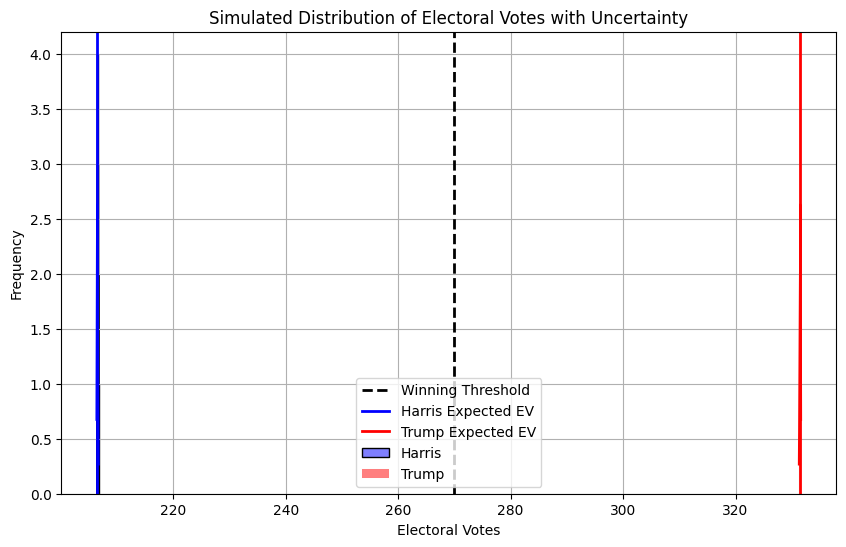

In [48]:
plot_ev_hist(results_df)

### GeoPlot of State-by-State Probabilities
* $P(Harris Wins) = Number of Harris Wins / Total Simulations$
    * If P(Harris Wins) > 0.9, strong Harris state
    * If P(Harris Wins) about 0.5, toss-up
    * If P(Harris Wins) < 0.1, strong Trump state



In [57]:
def simulate_election_state(voting_df, polling_df, weight_votes, weight_polls, baseline_uncertainty, n_sim):
    """
    Simulates the 2024 election using Bayesian Beta distribution.

    Returns:
    - DataFrame containing state-level win probabilities for Harris and Trump.
    """
    state_results = []

    # Loop over each state
    for _, row in voting_df.iterrows():
        state = row['State']
        electoral_votes = row["Electoral Votes"]
        total_votes = row["Trump Votes"] + row["Biden Votes"]

        # Check if polling data exists for this state
        poll_row = polling_df[polling_df['State'] == state]

        if not poll_row.empty:
            # Extract polling data
            polling_harris = float(poll_row["Democratic Result"].values[0].strip('%')) / 100
            polling_trump = float(poll_row["Trump Result"].values[0].strip('%')) / 100
        else:
            # No polling data, fallback to 2020 results
            polling_harris = row['Biden Votes'] / total_votes
            polling_trump = row['Trump Votes'] / total_votes

        # Compute weighted probability
        weighted_harris_votes = (polling_harris * weight_votes) + (polling_harris * weight_polls)
        weighted_trump_votes = (polling_trump * weight_votes) + (polling_trump * weight_polls)

        # Define Beta distribution parameters
        alpha_harris = weighted_harris_votes * total_votes + 1
        beta_harris = (1 - weighted_harris_votes) * total_votes + 1

        # Vectorized sampling: Run multiple simulations for the state
        samples = stats.beta.rvs(alpha_harris, beta_harris, size=n_sim)

        # Compute win probability
        harris_win_prob = np.mean(samples > 0.5)
        trump_win_prob = 1 - harris_win_prob

        # Store state-level probabilities
        state_results.append([state, electoral_votes, harris_win_prob, trump_win_prob])

    # Convert to DataFrame
    results_state_df = pd.DataFrame(state_results, columns=['State', 'Electoral Votes', 'Harris Win Probability', 'Trump Win Probability'])

    return results_state_df


In [69]:
# Run simulation
simulated_probabilities = simulate_election_state(voting_df, polling_df, weight_votes=0.5, weight_polls=0.5, baseline_uncertainty=0.01, n_sim=1000)
simulated_probabilities.head()

,State,Electoral Votes,Harris Win Probability,Trump Win Probability
0,Alabama,9,0.0,1.0
1,Alaska,3,0.0,1.0
2,Arizona,11,0.0,1.0
3,Arkansas,6,0.0,1.0
4,California,55,1.0,0.0


In [70]:
# Load US states shapefile
us_states = gpd.read_file("https://github.com/PublicaMundi/MappingAPI/raw/master/data/geojson/us-states.json")
us_states.head()

,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.3593 35.00118, -85.60668 34.9847..."
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,04,Arizona,57.050,"POLYGON ((-109.0425 37.00026, -109.04798 31.33..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


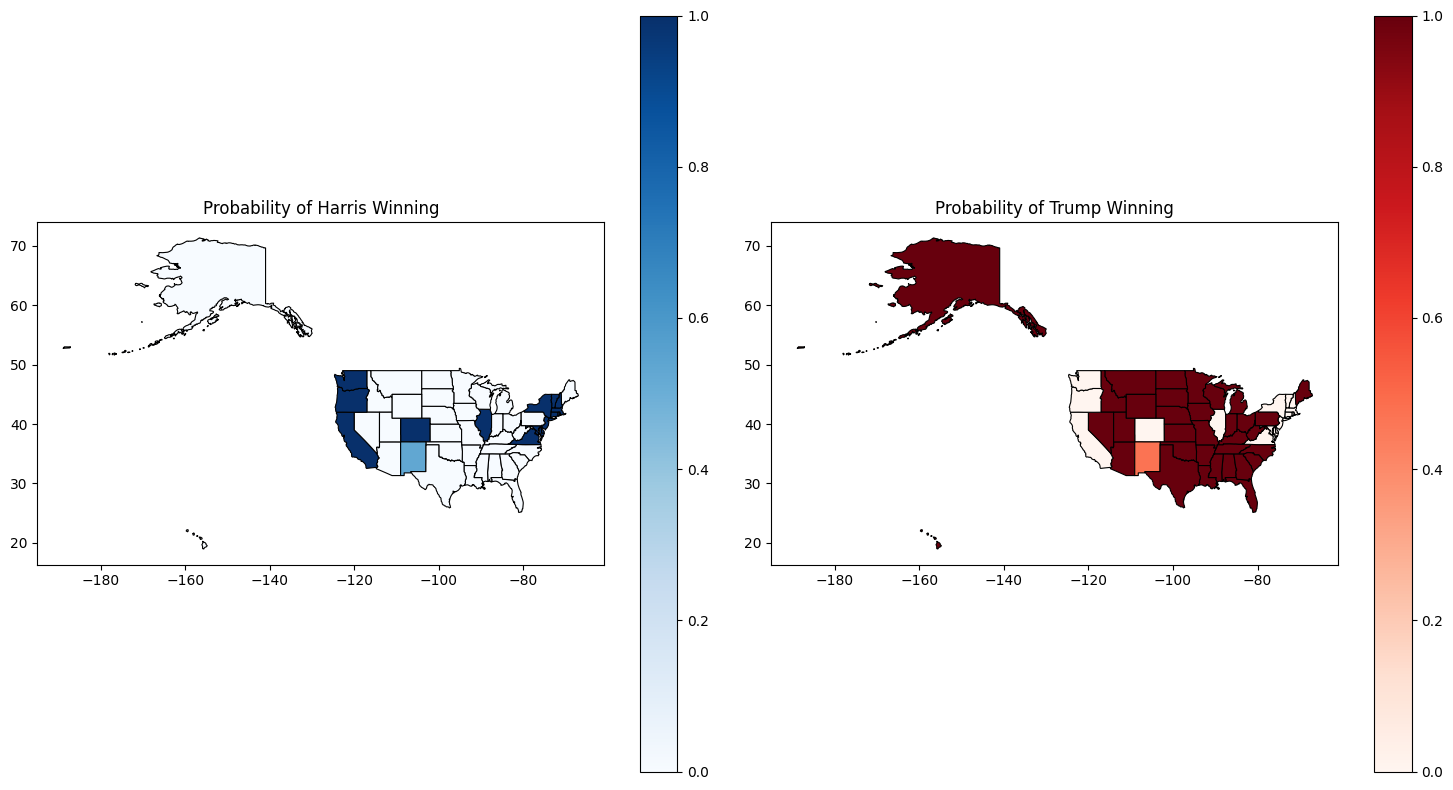

In [73]:
# Standardize state names for merging
us_states["State"] = us_states["name"].str.lower()
simulated_probabilities['State'] = simulated_probabilities['State'].str.lower()

# Merge probabilities with US state boundaries
us_states = us_states.merge(simulated_probabilities, left_on="State", right_on="State", how="left")

# Plot Harris win probability
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
us_states.plot(column="Harris Win Probability", cmap="Blues", linewidth=0.8, ax=axes[0], edgecolor="black", legend=True)
axes[0].set_title("Probability of Harris Winning")
us_states.plot(column="Trump Win Probability", cmap="Reds", linewidth=0.8, ax=axes[1], edgecolor="black", legend=True)
axes[1].set_title("Probability of Trump Winning")

plt.tight_layout()
plt.show()


### Conclusions & Findings:
We could see that there's higher probabilities that Trump would win more states than Harris on an uncertainty level of +-1%. 

In [60]:
results_df.harris_evotes.mean()

np.float64(206.50890000000004)

In [61]:
results_df.trump_evotes.mean()

np.float64(331.4911)

In [75]:
simulated_probabilities

,State,Electoral Votes,Harris Win Probability,Trump Win Probability
0,alabama,9,0.000,1.000
1,alaska,3,0.000,1.000
2,arizona,11,0.000,1.000
3,arkansas,6,0.000,1.000
4,california,55,1.000,0.000
5,colorado,9,1.000,0.000
6,connecticut,7,1.000,0.000
7,delaware,3,1.000,0.000
8,district of columbia,3,1.000,0.000
9,florida,29,0.000,1.000


#### Different outputs per scenarios (mean)
| Baseline Uncertainty | Harris | Trump |
| :------------------- |:-----: | ----: |
| 1%                   | 206    | 331   |